In [2]:
import pandas as pd
import networkx as nx
import torch
import torch.nn.functional as F
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv, global_mean_pool
from torch_geometric.loader import DataLoader
from sklearn.preprocessing import StandardScaler

# Load the dataset
file_path = 'data/MacroKAGCN.csv'
dataset = pd.read_csv(file_path)

In [3]:
# Select relevant features
features = [
    'Net trade in goods and services (BoP, current US$)',
    'GDP (current US$)',
    'Consumer price index (2010 = 100)',
    'Unemployment, total (% of total labor force) (national estimate)',
    'Exports of goods and services (BoP, current US$)',
    'Imports of goods and services (BoP, current US$)',
    'Foreign direct investment, net (BoP, current US$)'
]

# Drop rows with missing values for simplicity
cleaned_dataset = dataset.dropna(subset=features + ['Official exchange rate (LCU per US$, period average)'])


# Normalize the features
scaler = StandardScaler()
cleaned_dataset[features] = scaler.fit_transform(cleaned_dataset[features])

# Extract unique countries and years
selected_countries = cleaned_dataset['Country Code'].unique()[:6]
years = cleaned_dataset['Year'].str.extract(r'(\d+)').astype(int)[0].unique()
years.sort()

# Initialize the graph
G = nx.Graph()

In [4]:
# Adding nodes for each country and connecting them fully for each year
for year in years:
    previous_nodes = []
    for country in selected_countries:
        node_id = f"{country}_{year}"
        node_features = cleaned_dataset[(cleaned_dataset['Country Code'] == country) & (cleaned_dataset['Year'].str.contains(str(year)))][features].values[0]
        exchange_rate = cleaned_dataset[(cleaned_dataset['Country Code'] == country) & (cleaned_dataset['Year'].str.contains(str(year)))]['Official exchange rate (LCU per US$, period average)'].values[0]
        
        # Include exchange rate in the node attributes
        G.add_node(node_id, features=node_features, exchange_rate=exchange_rate)
        previous_nodes.append(node_id)

    # Add edges between every pair of nodes within the same year (complete graph for each year)
    for i in range(len(previous_nodes)):
        for j in range(i + 1, len(previous_nodes)):
            G.add_edge(previous_nodes[i], previous_nodes[j], weight=1)

In [5]:
# Prepare the dataset for PyTorch Geometric
def create_pyg_data(G):
    data_list = []
    for year in years:
        x = []
        edge_index = []
        y = []

        for i, country in enumerate(selected_countries):
            node_id = f"{country}_{year}"
            x.append(G.nodes[node_id]['features'])
            y.append(G.nodes[node_id]['exchange_rate'])

            for j in range(len(selected_countries)):
                if i != j:
                    target_node = f"{selected_countries[j]}_{year}"
                    edge_index.append([i, j])

        x = torch.tensor(x, dtype=torch.float)
        edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()
        y = torch.tensor(y, dtype=torch.float)

        data = Data(x=x, edge_index=edge_index, y=y)
        data_list.append(data)

    return data_list

data_list = create_pyg_data(G)
loader = DataLoader(data_list, batch_size=1, shuffle=False)

/var/folders/b7/1vzryjd55y9b0xdbmtml14980000gn/T/ipykernel_19530/4148825403.py:19: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:277.)
  x = torch.tensor(x, dtype=torch.float)


In [6]:
# Define the KAGCN model
class KAGCN(torch.nn.Module):
    def __init__(self):
        super(KAGCN, self).__init__()
        self.conv1 = GCNConv(in_channels=len(features), out_channels=16)
        self.conv2 = GCNConv(in_channels=16, out_channels=16)
        self.fc1 = torch.nn.Linear(16, 16)
        self.fc2 = torch.nn.Linear(16, 6)  # 6 output for each exchange rate prediction

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        x = F.relu(self.conv1(x, edge_index))
        x = F.relu(self.conv2(x, edge_index))
        x = global_mean_pool(x, data.batch)  # Global pooling for batch support

        x = F.relu(self.fc1(x))
        x = self.fc2(x)

        return x

In [8]:
# Training and evaluation
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = KAGCN().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)
criterion = torch.nn.MSELoss()

def train():
    model.train()

    total_loss = 0
    for data in loader:
        data = data.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, data.y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    
    return total_loss / len(loader)


In [9]:
def evaluate():
    model.eval()
    with torch.no_grad():
        for data in loader:
            data = data.to(device)
            output = model(data)
            # Add evaluation metrics here, such as MSE, MAE, etc.

In [10]:
# Training loop
for epoch in range(500):  # Example: 500 epochs
    loss = train()
    print(f'Epoch {epoch+1}, Loss: {loss:.4f}')

# After training, run evaluation
evaluate()

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([6])) that is different to the input size (torch.Size([1, 6])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 1, Loss: 115529.1685
Epoch 2, Loss: 76939.4935
Epoch 3, Loss: 104693.3513
Epoch 4, Loss: 72869.2825
Epoch 5, Loss: 303104.4810
Epoch 6, Loss: 149359.3741
Epoch 7, Loss: 148865.9344
Epoch 8, Loss: 148375.7224
Epoch 9, Loss: 147890.8056
Epoch 10, Loss: 147410.8018
Epoch 11, Loss: 146935.4124
Epoch 12, Loss: 146464.4201
Epoch 13, Loss: 145997.6443
Epoch 14, Loss: 145534.9691
Epoch 15, Loss: 145076.2759
Epoch 16, Loss: 144621.4653
Epoch 17, Loss: 144170.4742
Epoch 18, Loss: 143723.2254
Epoch 19, Loss: 143279.6590
Epoch 20, Loss: 142839.7261
Epoch 21, Loss: 142403.3660
Epoch 22, Loss: 141970.5454
Epoch 23, Loss: 141541.2108
Epoch 24, Loss: 141115.3209
Epoch 25, Loss: 140692.8581
Epoch 26, Loss: 140273.7570
Epoch 27, Loss: 139858.0088
Epoch 28, Loss: 139445.5671
Epoch 29, Loss: 139036.3951
Epoch 30, Loss: 138630.4747
Epoch 31, Loss: 138227.7745
Epoch 32, Loss: 137828.2608
Epoch 33, Loss: 137431.9022
Epoch 34, Loss: 137038.6795
Epoch 35, Loss: 136648.5652
Epoch 36, Loss: 136261.5326
Epo

In [11]:
def predict(model, data):
    model.eval()  # Set the model to evaluation mode
    data = data.to(device)  # Move data to the correct device (GPU or CPU)
    
    with torch.no_grad():  # Disable gradient computation for inference
        output = model(data)  # Forward pass through the model
        predictions = output.cpu().numpy()  # Convert predictions to numpy array (if needed)
    
    return predictions

# Example usage:
# Assuming `new_data` is a Data object for the year you want to predict
# Load your new data following the same structure as the training data

# Use the model to predict the exchange rates for the next year
for data in loader:
    predictions = predict(model, data)
print("Predicted exchange rates for the next year:", predictions)

Predicted exchange rates for the next year: [[  1.           0.84635484   1.193563   542.3302       2.506694
    0.7596491 ]]


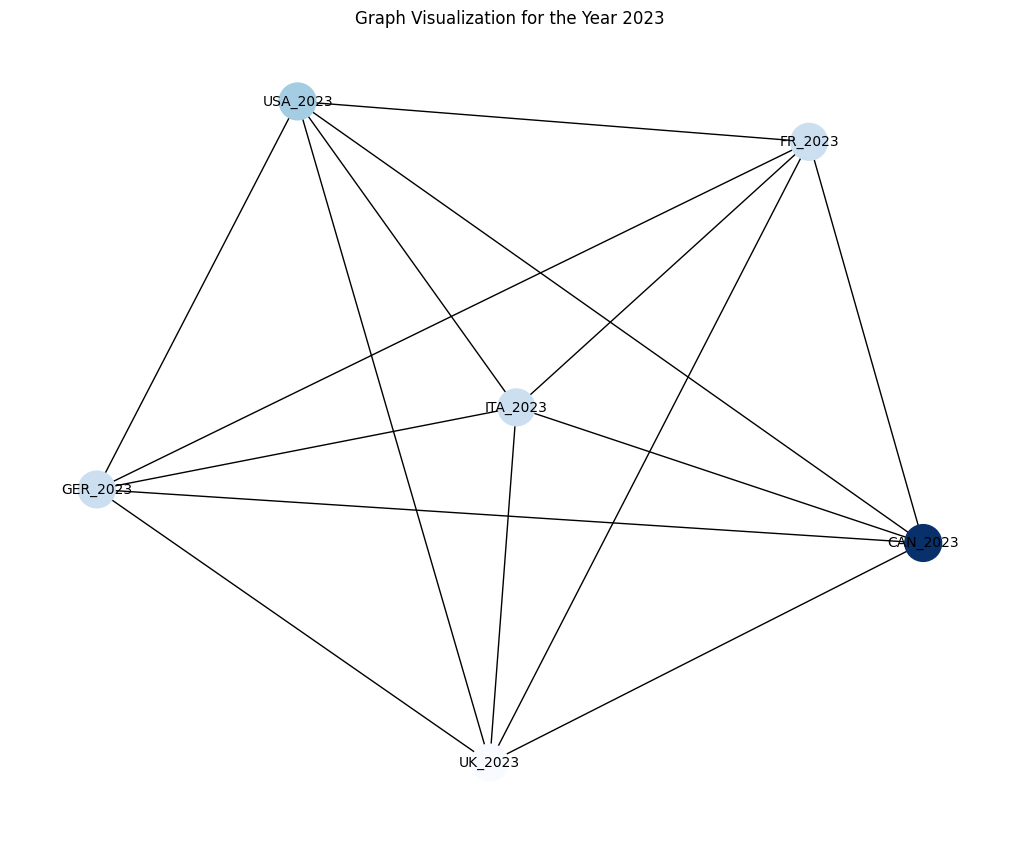

In [12]:
import matplotlib.pyplot as plt
import networkx as nx
from mpl_toolkits.axes_grid1 import make_axes_locatable

def visualize_graph(G, year):
    # Filter nodes to display only those for the specified year
    nodes_to_display = [node for node in G.nodes if node.endswith(f"_{year}")]
    
    # Create a subgraph for the specified year
    subgraph = G.subgraph(nodes_to_display)
    
    # Extract exchange rates for coloring
    exchange_rates = nx.get_node_attributes(subgraph, 'exchange_rate')
    
    # Define the node color map based on exchange rates
    node_colors = [exchange_rates[node] for node in subgraph.nodes]

    # Draw the graph
    plt.figure(figsize=(10, 8))
    pos = nx.spring_layout(subgraph)  # Positioning the nodes
    nx.draw(subgraph, pos, with_labels=True, node_color=node_colors, cmap=plt.cm.Blues, node_size=700, font_size=10)
    sm = plt.cm.ScalarMappable(cmap=plt.cm.Blues, norm=plt.Normalize(vmin=min(node_colors), vmax=max(node_colors)))
    sm.set_array([])
    plt.title(f"Graph Visualization for the Year {year}")
    plt.show()

# Example usage
year_to_visualize = 2023  # Replace with the year you want to visualize
visualize_graph(G, year_to_visualize)